# Project: ULMFiT as a Chemistry Language Model

In this notebook, we will use [ChEMBL 23](http://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_23/) dataset to train the Language Model (LM) on a self-supervised way.  ChEMBL 23 contains more than 1.5 million SMILES, we will train the Language Model to predict the next token. More specifically, we will model the probability of occuring an token given the previous m token.

## Acknowledgment

**Most of the code is adapted fron the the work of [Xinhao Li](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00430-x) his [github](https://github.com/XinhaoLi74/MolPMoFiT) and [Marcos Santana](https://www.researchgate.net/publication/346223430_De_Novo_Design_and_Bioactivity_Prediction_of_SARS-CoV-2_Main_Protease_Inhibitors_Using_ULMFit) his [github](https://github.com/Marcosuff)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import seaborn as sns
sns.set()
%matplotlib inline

## Data Loader

In [ ]:
!pip install fastai==2.1.4
!pip install fastcore==1.3.1

In [ ]:
import fastai
print(fastai.__version__)

from fastai.text.all import *

2.1.4


In [ ]:
import torch
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [ ]:
chembl = pd.read_csv('/content/drive/My Drive/Colab Notebooks/chembl23_sub200.csv')

In [ ]:
# Number of SMILES in ChEMBL23
len(chembl)

1717282

In [ ]:
chembl.rename(columns={"chembl_id": "chembl_id", "canonical_smiles": "Smiles", "vect_smiles": "vect_smiles"}, inplace=True)

In [ ]:
# WE TAKE A SUBSET OF ChEMBL23, IN ORDER TO TRAIN QUICKER
id_chose = np.random.choice(len(chembl),size=1_000_000, replace=False)

chembl = chembl.iloc[id_chose]

In [ ]:
chembl.head()

,chembl_id,Smiles,vect_smiles
1031110,CHEMBL1713601,Clc1ccccc1C(=O)N(Cc2ccc(Br)cc2)N3C(=O)CCCC3=O,"['Cl', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1', 'C', '(', '=', 'O', ')', 'N', '(', 'C', 'c', '2', 'c', 'c', 'c', '(', 'Br', ')', 'c', 'c', '2', ')', 'N', '3', 'C', '(', '=', 'O', ')', 'C', 'C', 'C', 'C', '3', '=', 'O']"
1412307,CHEMBL3229422,Br.NCc1cc(C(=O)N)n(n1)[C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O,"['Br', '.', 'N', 'C', 'c', '1', 'c', 'c', '(', 'C', '(', '=', 'O', ')', 'N', ')', 'n', '(', 'n', '1', ')', '[C@@H]', '2', 'O', '[C@H]', '(', 'C', 'O', ')', '[C@@H]', '(', 'O', ')', '[C@H]', '2', 'O']"
400284,CHEMBL465248,C[C@H]1CCC\C(=C\CC[C@@]2(C)O[C@H]2C[C@@H]3[C@@H](OC(=O)C3=C)[C@@H]1O)\C,"['C', '[C@H]', '1', 'C', 'C', 'C', '\\', 'C', '(', '=', 'C', '\\', 'C', 'C', '[C@@]', '2', '(', 'C', ')', 'O', '[C@H]', '2', 'C', '[C@@H]', '3', '[C@@H]', '(', 'O', 'C', '(', '=', 'O', ')', 'C', '3', '=', 'C', ')', '[C@@H]', '1', 'O', ')', '\\', 'C']"
344375,CHEMBL397312,CC(C)N1C[C@@H]([C@H](C1)c2ccc(Cl)cc2)C(=O)N3CCN(CC3)C4(CNCc5cocc5)CCCCC4,"['C', 'C', '(', 'C', ')', 'N', '1', 'C', '[C@@H]', '(', '[C@H]', '(', 'C', '1', ')', 'c', '2', 'c', 'c', 'c', '(', 'Cl', ')', 'c', 'c', '2', ')', 'C', '(', '=', 'O', ')', 'N', '3', 'C', 'C', 'N', '(', 'C', 'C', '3', ')', 'C', '4', '(', 'C', 'N', 'C', 'c', '5', 'c', 'o', 'c', 'c', '5', ')', 'C', 'C', 'C', 'C', 'C', '4']"
495651,CHEMBL558255,FC(F)(F)c1cccc(c1)C(=O)c2ccc3ccccc3n2,"['F', 'C', '(', 'F', ')', '(', 'F', ')', 'c', '1', 'c', 'c', 'c', 'c', '(', 'c', '1', ')', 'C', '(', '=', 'O', ')', 'c', '2', 'c', 'c', 'c', '3', 'c', 'c', 'c', 'c', 'c', '3', 'n', '2']"


In [ ]:
class MolTokenizer_v2():
  #source: https://github.com/Marcosuff/Marcosuff.github.io/tree/master/fastaiv2_works
  def tokenize_mols(self, t):
    pat = '(\[.*?\])' # Find special enviroments (e.g., [CH],[NH] etc)
    tokens = []
    t = t.replace('Br','L').replace('Cl','X') # Replace halogens
    atom_list = re.split(pat,t)
    for s in atom_list:
      if s.startswith('['):
        tokens.append(s)
      else:
        tokens += [x for x in list(s)]
    tokens = [x.replace('L','Br').replace('X','Cl') for x in tokens] # Decode halogens
    return [BOS] + tokens

  def __call__(self, items): return (self.tokenize_mols(t) for t in items)

In [ ]:
defaults.text_spec_tok
spec_toks = [BOS, PAD]

In [ ]:
d_block = DataBlock(blocks=TextBlock.from_df('Smiles',tok_text_col='Smiles',is_lm=True, # Pass is_lm = True since we are training a language model.
                                             tok=MolTokenizer_v2(), rules=[], min_freq=1), # Our tokenizer goes here and we define a minimum of 1
                    get_x=ColReader('Smiles'),
                    splitter=RandomSplitter(0.1)) # Randomply split the data (e.g., 90% for training and 10% for validation)
dls = d_block.dataloaders(chembl, bs=128, seq_len=50)
dls.show_batch(max_n=5)

,text,text_
0,xxbos O c 1 c c c ( c c 1 ) c 2 o c c ( C N 3 C C C C C C 3 ) n 2 xxbos O C ( = O ) c 1 c c c c ( C c 2 c c,O c 1 c c c ( c c 1 ) c 2 o c c ( C N 3 C C C C C C 3 ) n 2 xxbos O C ( = O ) c 1 c c c c ( C c 2 c c c
1,O ) N c 4 c c c c c 4 Br xxbos O = C ( N c 1 c c c c c 1 ) \ C = C \ c 2 c c c 3 [nH] c 4 c ( C C ( = O ) N,) N c 4 c c c c c 4 Br xxbos O = C ( N c 1 c c c c c 1 ) \ C = C \ c 2 c c c 3 [nH] c 4 c ( C C ( = O ) N c
2,4 ) n 5 C C C c 6 c c c c 3 c 5 6 ) C C 2 xxbos C c 1 c c c ( c c 1 ) S ( = O ) ( = O ) n 2 c c ( \ C =,) n 5 C C C c 6 c c c c 3 c 5 6 ) C C 2 xxbos C c 1 c c c ( c c 1 ) S ( = O ) ( = O ) n 2 c c ( \ C = N
3,) N C C c 3 c c c c c 3 ) C ( = O ) O ) C 2 xxbos C O c 1 c c c ( c c 1 ) [C@H] 2 C C ( = O ) C [C@@H] ( C C n 3,N C C c 3 c c c c c 3 ) C ( = O ) O ) C 2 xxbos C O c 1 c c c ( c c 1 ) [C@H] 2 C C ( = O ) C [C@@H] ( C C n 3 c
4,3 ) c c 1 2 ) c 4 c c c c ( c 4 ) C # N xxbos C S C C [C@H] ( N C ( = O ) [C@H] ( C ) N C ( = O ) [C@H] ( C C C C N,) c c 1 2 ) c 4 c c c c ( c 4 ) C # N xxbos C S C C [C@H] ( N C ( = O ) [C@H] ( C ) N C ( = O ) [C@H] ( C C C C N (


In [ ]:
pickle_out = open("/content/drive/My Drive/Colab Notebooks/ChemLM_DLoader_1M.pkl","wb")
pickle.dump(dls, pickle_out)
pickle_out.close()

# Model: ULMFiT

We will follow the Universal Language Model Fine-tuning (ULMFiT) by Howard and Ruber and adapt it in a Chemistry language SMILES. More specifically, we will use the AWD-LSTM (Averaged stochastic gradient descent Weight-Dropped LSTM) which is a variation of the Long Sort-Term Memory model (LSTM) with various kinds of dropouts in embedding layer, input layer, weights, and hidden layers.

![lstm](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

![lstm legend](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM2-notation.png)

source: https://colah.github.io/posts/2015-08-Understanding-LSTMs/  by Christopher Olah

The explanations and equations for the LSTMs are based on: the course of Stanford University ["CS 230 - Deep Learning"](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks) on the section of RNNs, and on the blogpost ["Understanding LSTMs"](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Christopher Olah. Bellow we use $<t>$ to denote time step t, $\widetilde{c}^{<t>}$ is the candidate value for the memory cell at time step t and $c^{<t>}$ is the memory cell at time step t. The notation $[h^{<t-1>},x^{<t>}]$ denotes the two vectors $h^{<t-1>}$ (the hidden state at time step t-1) and $x^{<t>}$ (the input vector at time step t) stuck one on top of the other to create a long vector. Using the notation of the two stacked vectors makes easier to see the feed-forward layers. The parameters to learn are the four weight matrices $W_c$, $W_u$, $W_f$ and $W_o$ with their corresponding biases $b_c$, $b_u$, $b_f$ and $b_o$. 

<br>

* First, the "forget gate layer" $f^{<t>}$ decide the information that will be dropped from the cell state. It takes as input the concatenation of the vectors $h^{<t-1>}$ and $x^{<t>}$ and passes it through the sigmoid function, the output is then between 0 and 1; the closer to 1 is the more information passes through. 
$$f^{<t>}=\sigma(W_f[h^{<t-1>},x^{<t>}]+b_f)$$

<br>

* Next the "input gate layer" $i^{<t>}$ define which values will be updated. 
$$i^{<t>}=\sigma(W_u[h^{<t-1>},x^{<t>}]+b_u)$$

<br/>

* The "update candidate cell layer" creates the candidate cell values $\widetilde{c}^{<t>}$ that could be added to the cell. 
$$\widetilde{c}^{<t>}=\tanh(W_c[h^{<t-1>},x^{<t>}]+b_c)$$

<br/>

* Now we can update the old memory cell by adding the $f^{<t>} \odot c^{<t-1>}$ with $i^{<t>} \odot \widetilde{c}^{<t>}$, where the symbol $\odot$ denotes the element wise multiplication.
$$c^{<t>}=f^{<t>} \odot c^{<t-1>}+i^{<t>} \odot \widetilde{c}^{<t>}$$

<br/>

* Finally, the "output gate layer" $o^{<t>}$ will multiplied element wise with the tanh of cell state; in order to filter it to produce the next hidden state. 
$$o^{<t>}=\sigma(W_o[h^{<t-1>},x^{<t>}]+b_o) $$
$$h^{<t>}=o^{<t>} \odot \tanh(c^{<t>})$$

In [ ]:
class LikeULMFit(Module):
    def __init__(self, vocab_sz, emb_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, emb_sz)
        self.rnn = nn.LSTM(emb_sz, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight  # weight tying
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(n_layers)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h] # truncated BPTT
        return self.h_o(out),raw,out
    
    def reset(self): #we call reset() in the start of each epoch
        for h in self.h: h.zero_()

In [ ]:
# learn = Learner(dls, AWD_LSTM(vocab_sz=len(vocab),emb_sz=64, n_hid=64, n_layers=2, weight_p=0.5),
#                 loss_func=CrossEntropyLossFlat(), metrics=accuracy,
#                 cbs=[ModelResetter, RNNRegularizer(alpha=2, beta=1)]) # .to_fp16()

In [ ]:
# if we want to use less hidden nodes
# config = awd_lstm_lm_config.copy()
# config.update({'n_hid':512})

In [ ]:
awd_lstm_lm_config

{'bidir': False,
 'emb_sz': 400,
 'embed_p': 0.02,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'n_hid': 1152,
 'n_layers': 3,
 'out_bias': True,
 'output_p': 0.1,
 'pad_token': 1,
 'tie_weights': True,
 'weight_p': 0.2}

In [ ]:
learn = language_model_learner(dls,AWD_LSTM,drop_mult=0.3, #,config=config
                               pretrained=False,metrics=[accuracy, Perplexity()]).to_fp16()

In [ ]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(240, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(240, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=240, bias=True)
    (output_dp): RNNDropout()
  )
)

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0010000000474974513)

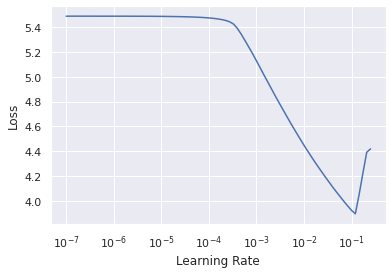

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(11, 0.001)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.808705,0.744430,0.751432,2.105241,42:06
1,0.645287,0.609034,0.792754,1.838655,41:58
2,0.596357,0.565785,0.806603,1.760829,42:04
3,0.564727,0.542389,0.814403,1.720111,41:57
4,0.547245,0.525931,0.819887,1.692033,41:59
5,0.530607,0.510794,0.825182,1.666614,41:59
6,0.507727,0.496234,0.830005,1.642525,42:05
7,0.486917,0.483895,0.834285,1.622381,42:12
8,0.480076,0.475347,0.837316,1.608572,42:08
9,0.461619,0.471243,0.838832,1.601984,42:05


In [ ]:
learn.save('/content/drive/My Drive/Colab Notebooks/ChemLMModel_11ep_FullAWDLSTM')

Path('/content/drive/My Drive/Colab Notebooks/Projects_Mol_ULMFiT/ChemLMModel_11ep_FullAWDLSTM.pth')

In [ ]:
pickle_out = open("/content/drive/My Drive/Colab Notebooks/vocab_11ep_FullAWDLSTM.pkl","wb")
pickle.dump(learn.dls.vocab, pickle_out)
pickle_out.close()

In [ ]:
def sampler_test(model, text, temperature, max_size):
    #source: https://github.com/Marcosuff/Marcosuff.github.io/tree/master/fastaiv2_works
    model.model.reset()
    nums = model.dls.train_ds.numericalize
    idxs = idxs_all = model.dls.test_dl([text]).items[0]#.to(model.dls.device)
    for _ in range(max_size):

    preds,_ = model.get_preds(dl=[(idxs[None],)])
    res = preds[0][-1]
    if temperature != 1.: res.pow_(1 / temperature)
    idx = torch.multinomial(res, 1).item()
    if idx != 0:
        idxs = idxs_all = torch.cat([idxs_all, idxs.new([idx])])
    else:
        break

    return ''.join([nums.vocab[i] for i in idxs_all if nums.vocab[i] not in [BOS, PAD]])

In [ ]:
learn.export()

In [ ]:
# !mv /content/export.pkl /content/drive/My\ Drive/Colab\ Notebooks

In [ ]:
learn_inf = load_learner('/content/drive/My Drive/Colab Notebooks/export.pkl')

In [ ]:
mols = [sampler_test(model=learn_inf,text='',temperature=0.7,max_size=120) for _ in range(10)]

In [ ]:
mols

['COc1ccc(CCNC(=O)c2ccc(NS(=O)(=O)c3ccc(Cl)cc3)cc2)cc1',
 'COc1ccc(cc1)S(=O)(=O)N(C)C[C@H]2Oc3ccc(NC(=O)NC4CCCCC4)cc3C(=O)N(C[C@@H]2C)[C@H](C)CO',
 'CC(C)C[C@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](C)NC(=O)[C@@H](N)CO)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](CCCCN)C(=',
 'CC(C)(C)C1=C(N2[C@H](O1)[C@@H](CNC(=O)Cc3cccs3)C2=O)C(=O)O',
 'CCOc1ccccc1NC(=O)c2cc(C(=O)N3CCCCC3)c(O)c(CN4CCOCC4)c2',
 'CN1CCN(CC1)C2=C(C=O)C(=O)N3C=CC=C(C)C3=N2',
 'COc1cc(cc(Cl)c1O)c2ccc3ncc(C(=O)C4CC4)c(Nc5ccc(cc5OC)C6=NCCN6)c3c2',
 'CC(N1C(=O)c2ccccc2C1=O)C(=O)Nc3ccc4OCCOc4c3',
 'CCOC(=O)c1ccc(NC(=O)CSc2nc(O)c3c4CCCCc4sc3n2)cc1',
 'COc1cccc(NC(=O)C(=O)Nc2ccccc2N3CCOCC3)c1OC']

How many **valid** molecules did we generate?

In [ ]:
valid_mols = [x for x in mols if MolFromSmiles(x)]
print('Percentage of valid SMILES:{:.2f}%'.format(100*len(valid_mols)/len(mols)))

How many molecules are **novel** (i.e., not present on the training set)?

In [ ]:
novel_mols = set.difference(set(valid_mols),set(chembl.Smiles))
print('Percentage of novel SMILES:{:.2f}%'.format(100*len(novel_mols)/len(valid_mols)))

Percentage of novel SMILES:90.00%


# References:

[1] [Weininger D (1988) SMILES, a chemical language and information system. 1. Introduction to methodology and encoding rules. J Chem Inf Model 28:31–36. https ://doi.org/10.1021/ci000 57a005](https://pubs.acs.org/doi/10.1021/ci00057a005)

[2] [Li, Xinhao; Fourches, Denis (2020): SMILES Pair Encoding: A Data-Driven Substructure Tokenization Algorithm for Deep Learning. ChemRxiv. Preprint. https://doi.org/10.26434/chemrxiv.12339368.v1](https://chemrxiv.org/articles/SMILES_Pair_Encoding_A_Data-Driven_Substructure_Tokenization_Algorithm_for_Deep_Learning/12339368)

[3] [Li, X., Fourches, D. Inductive transfer learning for molecular activity prediction: Next-Gen QSAR Models with MolPMoFiT. J Cheminform 12, 27 (2020). https://doi.org/10.1186/s13321-020-00430-x](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00430-x)

[4] [Marcos Santana, Floriano Paes Silva. De Novo Design and Bioactivity Prediction of SARS-CoV-2 Main Protease Inhibitors Using ULMFit (2020)](https://www.researchgate.net/publication/346223430_De_Novo_Design_and_Bioactivity_Prediction_of_SARS-CoV-2_Main_Protease_Inhibitors_Using_ULMFit)

[5] [Howard J, Ruder S (2018) Universal language model fine-tuning for text
classification. http://arxiv .org/abs/1801.06146](https://arxiv.org/abs/1801.06146)

[6] [Smith LN (2018) A disciplined approach to neural network hyper-parameters:
Part 1: learning rate, batch size, momentum, and weight decay. http://arxiv .org/abs/1803.09820](https://arxiv.org/abs/1803.09820)


[7] [The RDKit Documentation — The RDKit 2020.03.1 documentation. URLhttps://rdkit.org/docs/index.html.](https://rdkit.org/docs/index.html)
